Importing nessacry libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tkinter as tk
from tkinter import messagebox



Loading And Merging the datasets 

In [2]:
# Load datasets
fake_df = pd.read_csv('fake.csv')
true_df = pd.read_csv('true.csv')

# Add a label column
fake_df['label'] = 0  
true_df['label'] = 1  

#shapes
print("Fake News Shape:", fake_df.shape)
print("True News Shape:", true_df.shape)

# Combine and shuffle
data = pd.concat([fake_df, true_df], axis=0).sample(frac=1).reset_index(drop=True)


Fake News Shape: (23481, 5)
True News Shape: (21417, 5)


In [3]:
data.head()

,title,text,subject,date,label
0,Trump spokesman to brief press on Thursday,(Reuters) - Donald Trump’s spokesman said his ...,politicsNews,"January 18, 2017",1
1,This Important Video Sums Up Why Donald Trump...,Despite the damage that the presidency of Geor...,News,"April 13, 2016",0
2,OOPS: Trump’s Hotel Offers Qurans And Is Furn...,Donald Trump wanted the press to tour his bran...,News,"September 16, 2016",0
3,Marseille attack suspect had shown Tunisian pa...,PARIS (Reuters) - The man suspected of carryin...,worldnews,"October 2, 2017",1
4,"Congress revisits Obamacare, this time with a ...",WASHINGTON (Reuters) - The U.S. Congress was w...,politicsNews,"September 12, 2017",1


In [19]:
print('Total Number of fake news : ',data[data['label']== 0].shape[0])
print('Total Number of true news : ',data[data['label']== 1].shape[0])

Total Number of fake news :  23481
Total Number of true news :  21417


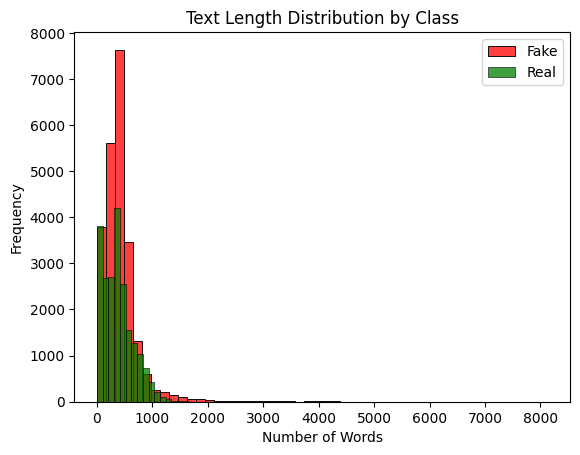

In [21]:
#plotting text lenght for both fake and true news
data['text_length'] = data['text'].apply(lambda x: len(str(x).split()))

sns.histplot(data[data['label']==0]['text_length'], bins=50, color='red', label='Fake', kde=False)
sns.histplot(data[data['label']==1]['text_length'], bins=50, color='green', label='Real', kde=False )
plt.legend()
plt.title("Text Length Distribution by Class")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [32]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

data['cleaned_text'] = data['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to C:\Users\Inshal
[nltk_data]     Munaf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Inshal
[nltk_data]     Munaf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
data.head()

,title,text,subject,date,label,cleaned_text
0,Alec Baldwin Just Put Trump’s Idiot Supporter...,Saturday Night Live returned with a stellar co...,News,"April 9, 2017",0,saturday night live returned stellar cold open...
1,Tokyo Governor Koike: No need for big change i...,"TOKYO (Reuters) - Tokyo Governor Yuriko Koike,...",worldnews,"October 6, 2017",1,tokyo reuters tokyo governor yuriko koike whos...
2,WATCH Huge Crowd Of Muslims Admit That ALL Mus...,https://www.youtube.com/watch?v=8Mehk5eWcZA,left-news,"Feb 8, 2017",0,httpswwwyoutubecomwatchv8mehk5ewcza
3,Vietnam orders prosecution of oil firm officia...,HANOI (Reuters) - Vietnamese police have order...,worldnews,"December 19, 2017",1,hanoi reuters vietnamese police ordered prosec...
4,Maine’s Governor Refuses To Answer One Simple...,The Rachel Maddow Show attempted to reach out ...,News,"January 26, 2016",0,rachel maddow show attempted reach maine gover...


C:\Users\Inshal Munaf\AppData\Local\Temp\ipykernel_20844\3268291420.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette="viridis")


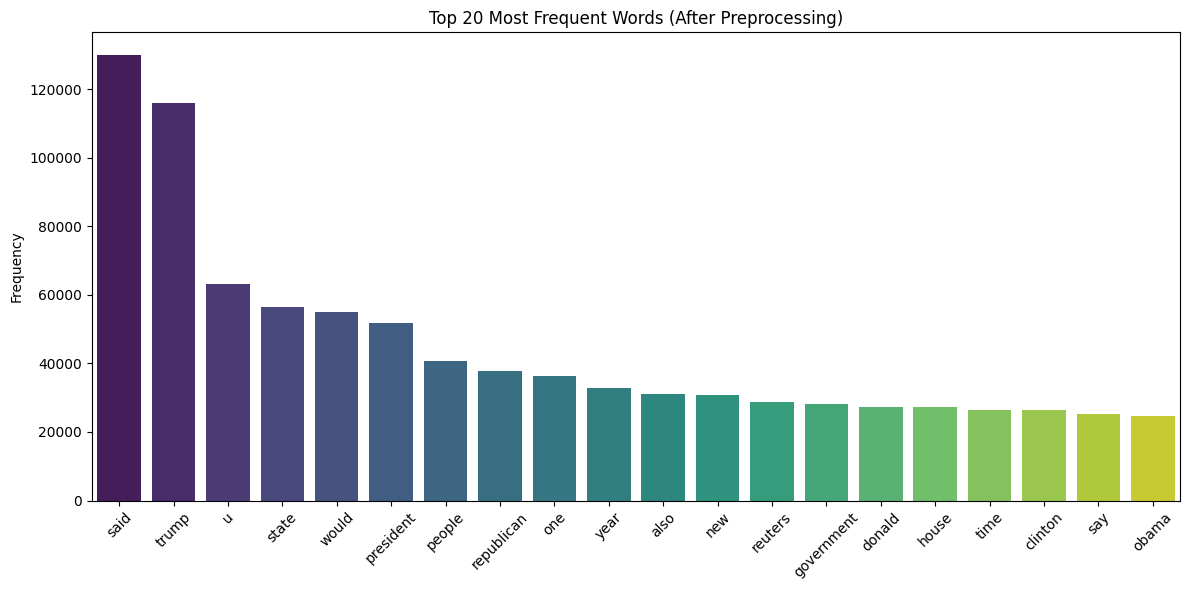

In [33]:
from collections import Counter

# Join all cleaned words
all_words = ' '.join(data['cleaned_text']).split()

# Count word frequencies
word_counts = Counter(all_words)

# Get the top 20 most common words
top_words = word_counts.most_common(20)

# Separate words and their counts
words, counts = zip(*top_words)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=list(words), y=list(counts), palette="viridis")
plt.title("Top 20 Most Frequent Words (After Preprocessing)")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\Inshal Munaf\AppData\Local\Temp\ipykernel_20844\2905020025.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(fake_words), y=list(fake_counts), palette='Reds_r')
C:\Users\Inshal Munaf\AppData\Local\Temp\ipykernel_20844\2905020025.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(real_words), y=list(real_counts), palette='Greens_r')


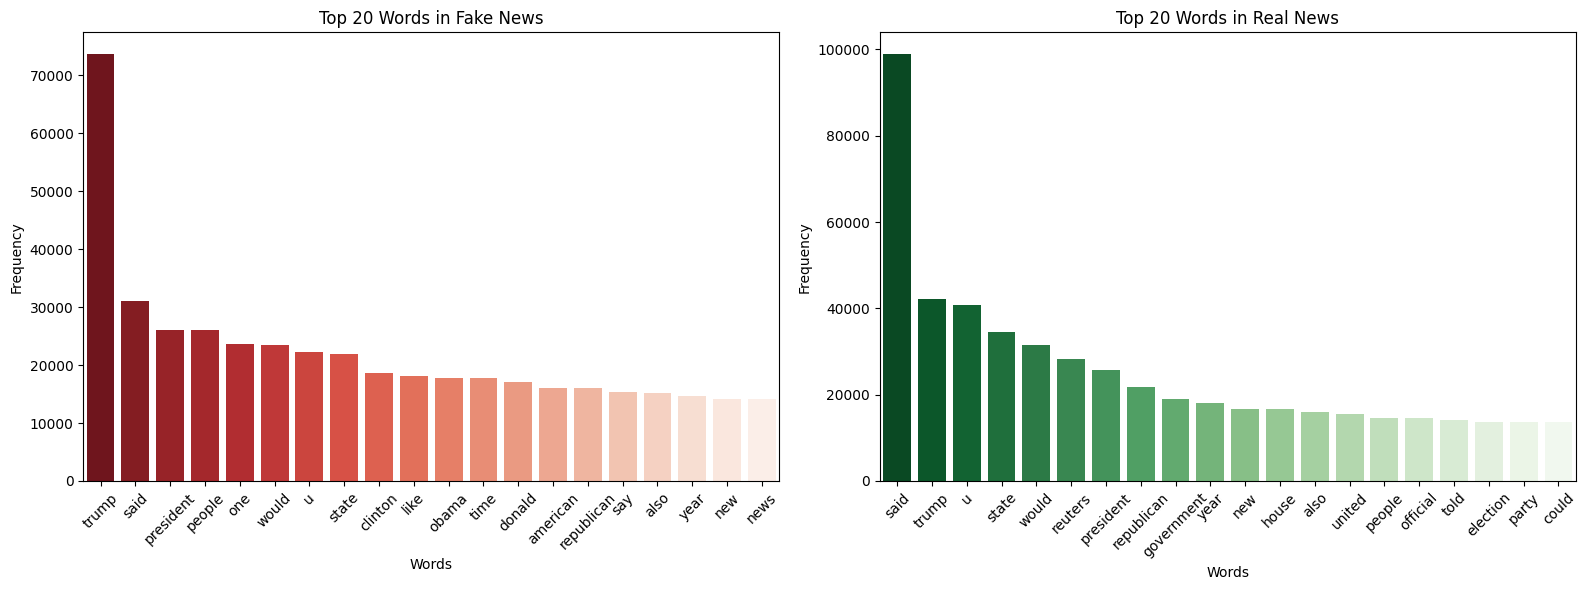

In [36]:
def get_top_words(text_series, top_n=20):
    all_words = ' '.join(text_series).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

# Get top words for fake and real news
top_fake = get_top_words(data[data['label'] == 0]['cleaned_text'], 20)
top_real = get_top_words(data[data['label'] == 1]['cleaned_text'], 20)

# Convert to plot-friendly format
fake_words, fake_counts = zip(*top_fake)
real_words, real_counts = zip(*top_real)

# Plot side by side
plt.figure(figsize=(16, 6))

# Fake News plot
plt.subplot(1, 2, 1)
sns.barplot(x=list(fake_words), y=list(fake_counts), palette='Reds_r')
plt.title("Top 20 Words in Fake News")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.xlabel("Words")

# Real News plot
plt.subplot(1, 2, 2)
sns.barplot(x=list(real_words), y=list(real_counts), palette='Greens_r')
plt.title("Top 20 Words in Real News")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.xlabel("Words")

plt.tight_layout()
plt.show()

Converting the text into vectors

In [34]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['cleaned_text']).toarray()
y = data['label']


Splitting the data 

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [42]:
print("Lenght of X _train : ",len(X_train))
print("Lenght of Y _train : ",len(y_train))
print("Lenght of X _test : ",len(X_test))
print("Lenght of Y _test : ",len(y_test))

Lenght of X _train :  35918
Lenght of Y _train :  35918
Lenght of X _test :  8980
Lenght of Y _test :  8980


Training the model (Logistic)

In [43]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)


Training the model (NaiveBayes)

In [44]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)


Model Evaluation

In [45]:
def evaluate_model(y_true, y_pred, name):
    print(f"--- {name} Evaluation ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

evaluate_model(y_test, log_preds, "Logistic Regression")
evaluate_model(y_test, nb_preds, "Naive Bayes")


--- Logistic Regression Evaluation ---
Accuracy: 0.9902004454342984
Confusion Matrix:
 [[4678   51]
 [  37 4214]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4729
           1       0.99      0.99      0.99      4251

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

--- Naive Bayes Evaluation ---
Accuracy: 0.950445434298441
Confusion Matrix:
 [[4491  238]
 [ 207 4044]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      4729
           1       0.94      0.95      0.95      4251

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



Confusion Matrix ---> Logistic Regression

In [ ]:
# Generate predictions
log_preds = log_model.predict(X_test)

# Compute confusion matrix
cm_log = confusion_matrix(y_test, log_preds)

# Plot using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [50]:
import tkinter as tk
from tkinter import ttk

def predict_news():
    input_text = entry.get("1.0", "end-1c")
    clean_input = clean_text(input_text)
    vec_input = vectorizer.transform([clean_input]).toarray()

    selected_model = model_var.get()
    if selected_model == "Logistic Regression":
        prediction = log_model.predict(vec_input)[0]
    else:
        prediction = nb_model.predict(vec_input)[0]

    result = "✅ Real News" if prediction == 1 else "❌ Fake News"
    result_label.config(
        text=f"Prediction: {result}",
        fg="green" if prediction == 1 else "red"
    )

# Create main window
window = tk.Tk()
window.title("📰 Fake News Detection")
window.geometry("650x450")
window.configure(bg="#f8f9fa")

# Title Label
title = tk.Label(window, text="🧠 Fake News Detector", font=("Helvetica", 20, "bold"), bg="#f8f9fa", fg="#2c3e50")
title.pack(pady=20)

# Model selection dropdown
model_frame = tk.Frame(window, bg="#f8f9fa")
model_frame.pack(pady=5)

tk.Label(model_frame, text="Select Model:", font=("Helvetica", 12), bg="#f8f9fa").pack(side="left", padx=5)

model_var = tk.StringVar(value="Logistic Regression")
model_dropdown = ttk.Combobox(model_frame, textvariable=model_var, values=["Logistic Regression", "Naive Bayes"], font=("Helvetica", 11), state="readonly", width=20)
model_dropdown.pack(side="left", padx=10)

# Text Entry
input_frame = tk.Frame(window, bg="#f8f9fa")
input_frame.pack(padx=20, pady=10, fill="both", expand=True)

tk.Label(input_frame, text="Enter News Content:", font=("Helvetica", 12), bg="#f8f9fa").pack(anchor="w")

entry = tk.Text(input_frame, height=10, font=("Helvetica", 11), wrap="word", bd=1, relief="solid")
entry.pack(fill="both", expand=True, pady=5)

# Predict Button
predict_button = tk.Button(window, text="🔍 Predict", command=predict_news, font=("Helvetica", 13, "bold"), bg="#007BFF", fg="white", padx=15, pady=8)
predict_button.pack(pady=15)

# Result Label
result_label = tk.Label(window, text="", font=("Helvetica", 14, "bold"), bg="#f8f9fa")
result_label.pack(pady=10)

# Start GUI
window.mainloop()


In [47]:
data['text'].head()

0    Saturday Night Live returned with a stellar co...
1    TOKYO (Reuters) - Tokyo Governor Yuriko Koike,...
2          https://www.youtube.com/watch?v=8Mehk5eWcZA
3    HANOI (Reuters) - Vietnamese police have order...
4    The Rachel Maddow Show attempted to reach out ...
Name: text, dtype: object